# Quick, Draw! Doodle Recognition Challenge
 - https://www.kaggle.com/c/quickdraw-doodle-recognition
 
"Quick, Draw!" was released as an experimental game to educate the public in a playful way about how AI works. The game prompts users to draw an image depicting a certain category, such as ”banana,” “table,” etc. The game generated more than 1B drawings, of which a subset was publicly released as the basis for this competition’s training set. That subset contains 50M drawings encompassing 340 label categories.

Sounds fun, right? Here's the challenge: since the training data comes from the game itself, drawings can be incomplete or may not match the label. You’ll need to build a recognizer that can effectively learn from this noisy data and perform well on a manually-labeled test set from a different distribution.

Your task is to build a better classifier for the existing Quick, Draw! dataset. By advancing models on this dataset, Kagglers can improve pattern recognition solutions more broadly. This will have an immediate impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).

In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./test_simplified.csv')
df['drawing'] = df['drawing'].apply(ast.literal_eval)

In [3]:
df.head()

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


## target 그림 훑어보기

In [4]:
df_show = df.iloc[:25]

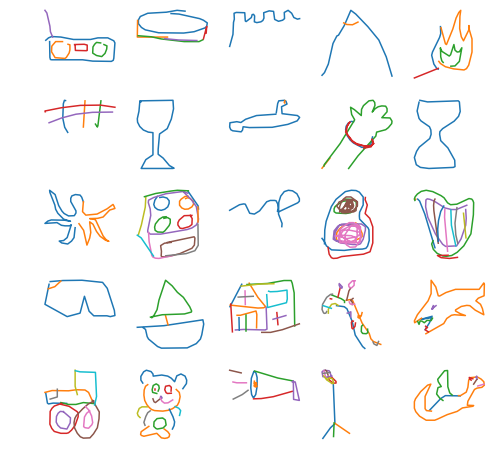

In [5]:
n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(8, 8))
for i, drawing in enumerate(df_show['drawing']):
    ax = axs[i//n, i%n]
    for x, y in drawing:
        ax.plot(x, -np.array(y))
    ax.axis('off')
plt.show()

### 'drawing'은 그래프상 점의 좌표(x,y)로 구성되어 있음
- 점들을 연결하여 여러 개의 선분을 표현하여 그림을 그리는 것


In [6]:
df_show['drawing'].apply(np.array).apply(np.shape)[:10]

0        (5, 2)
1        (5, 2)
2    (1, 2, 31)
3        (2, 2)
4        (5, 2)
5        (5, 2)
6    (1, 2, 25)
7        (2, 2)
8        (4, 2)
9    (1, 2, 29)
Name: drawing, dtype: object

## Neural Net 학습에 용이하게 224x224 정방 사진 형태로 변환

In [7]:
import cv2

In [8]:
def to_pixel_matrix(drawing_ls, size=224, lw=6, time_color=True):
    '''
    점의 좌표(x,y)로 이뤄진 list를 224x224 정방형 pixel matrix로 변환하는 함수
    
    arguments
    ===============================================
    drawing_ls : list
        - 사진을 표현한 그래프 좌표(x,y)가 담긴 리스트
        - 'drawings' column
    
    size : int, default=224
        - pixel matrix의 길이 
        - default=224는 ResNet101의 default input size
    
    lw : int
        - tickness, 선분의 두께 
        
    time_color = bool
        - True : 선의 색(color)을 decay 시켜 선을 그리는 순서를 표현, 그림을 그리는 패턴을 포착하기 위함
        - False : 동일한 색으로 선을 표현
    '''
    base_size = 256
    img = np.zeros((base_size, base_size), np.uint8)
    for t, drawing in enumerate(drawing_ls):
        for i in range(len(drawing[0]) - 1):
            color = 255 - min(t, 10)*20 if time_color else 255
            img = cv2.line(
                img, 
                (drawing[0][i], drawing[1][i]),
                (drawing[0][i + 1], drawing[1][i + 1]), 
                color=color, 
                thickness=lw,
            )
    
    return cv2.resize(img, (size, size))

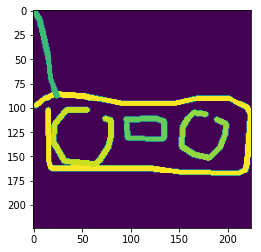

In [9]:
img = to_pixel_matrix(df_show['drawing'][0], time_color=True, lw=5)
plt.imshow(img)

In [10]:
img.shape

(224, 224)

# EDA

In [11]:
from collections import Counter
import seaborn as sns

In [12]:
df = pd.concat([chunk for chunk in pd.read_csv('total_train.csv', chunksize=100000)])

In [13]:
len(df)

49707579

In [14]:
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[68, 62, 67, 62, 54, 6, 1, 0, 4, 21, 45, 71,...",5449510329253888,True,2017-03-29 14:37:36.166140,broccoli
1,US,"[[[128, 55, 1, 15, 47, 86, 137, 133, 126], [9,...",6440653254819840,True,2017-03-17 03:25:22.455460,toilet
2,US,"[[[60, 149, 255, 248, 197], [1, 0, 3, 10, 29]]...",6233045407367168,True,2017-03-19 02:28:53.767320,table
3,CZ,"[[[11, 7, 7, 18, 36, 50, 77, 128, 159, 171, 18...",5387809869266944,True,2017-03-21 09:40:55.003330,coffee cup
4,CA,"[[[0, 10, 8, 13, 28, 41, 57, 101, 118, 197, 22...",6496964067721216,True,2017-03-25 14:32:31.544710,helmet


In [15]:
df.columns

Index(['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word'], dtype='object')

## Word

In [16]:
len(set(df['word']))

340

In [17]:
word_frequency_dic = Counter(df['word'])

In [18]:
most_frequent_words = sorted(((val, key) for key, val in word_frequency_dic.items()), reverse=True)

In [19]:
most_frequent_words[:10]

[(340029, 'snowman'),
 (329204, 'potato'),
 (321981, 'calendar'),
 (319136, 'marker'),
 (307936, 'banana'),
 (291773, 'hand'),
 (290239, 'diving board'),
 (285403, 'harp'),
 (280442, 'yoga'),
 (271444, 'cooler')]

In [20]:
most_frequent_words[-10:]

[(116870, 'piano'),
 (116804, 'leg'),
 (116685, 'snowflake'),
 (116677, 'tractor'),
 (116535, 'stove'),
 (116502, 'whale'),
 (116313, 'screwdriver'),
 (115413, 'ceiling fan'),
 (113862, 'bed'),
 (113613, 'panda')]

### class-imbalance는 심각하지 않은 것으로 보임

## Country Code

In [21]:
len(set(df['countrycode']))

218

In [22]:
most_frequent_codes = sorted(((val, key) for key, val in Counter(df['countrycode']).items()), reverse=True)

In [23]:
most_frequent_codes[:10]

[(22196140, 'US'),
 (3598059, 'GB'),
 (1817868, 'CA'),
 (1552337, 'DE'),
 (1173343, 'AU'),
 (1158652, 'RU'),
 (880601, 'BR'),
 (856386, 'SE'),
 (846828, 'FI'),
 (800313, 'CZ')]

### US가 전체 데이터의 40% 이상을 차지

In [24]:
most_frequent_codes[-10:]

[(11, 'VU'),
 (6, 'TL'),
 (6, 'GN'),
 (6, 'CG'),
 (2, 'IR'),
 (2, 'GM'),
 (2, 'BI'),
 (1, 'SS'),
 (1, 'SJ'),
 (1, 'NF')]

### 상위 30개 국에서, 어떤 그림이 많은지 체크

In [25]:
from collections import defaultdict

In [26]:
ratio_dic = defaultdict(lambda:[])

for _, code in most_frequent_codes[:30]:
    temp_df = df[df['countrycode'] == code]['word']
    counter = Counter(temp_df)
    
    for word, count in counter.items():
        count /= len(temp_df) # 각 label의 비율을 계산
        ratio_dic[word].append(count)


Text(0.5, 1.0, 'baseball')

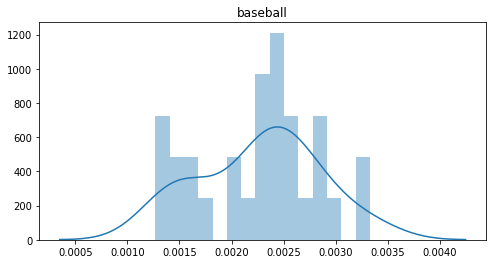

In [27]:
label = 'baseball'
plt.figure(figsize=(8,4))
sns.distplot(ratio_dic[label], bins=15)
plt.title(label)

Text(0.5, 1.0, 'yoga')

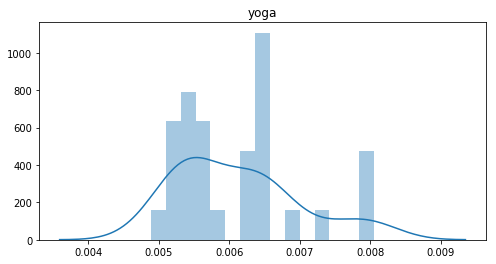

In [28]:
label = 'yoga'
plt.figure(figsize=(8,4))
sns.distplot(ratio_dic[label], bins=15)
plt.title(label)

Text(0.5, 1.0, 'horse')

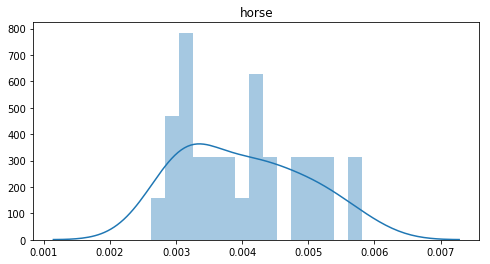

In [29]:
label = 'horse'
plt.figure(figsize=(8,4))
sns.distplot(ratio_dic[label], bins=15)
plt.title(label)

### 시사점
 - 나라마다 자주 등장하는 그림이 다름
 - 따라서, 데이터의 상당 수를 차지하는 미국의 그림 비율은 유용한 정보가 될 수 있을 것으로 예상됨


### recognized

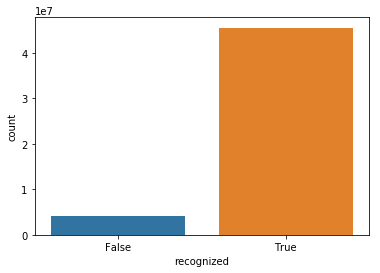

In [30]:
sns.countplot(x="recognized", data=df)

In [31]:
recognize_failed_dic = Counter(df[df['recognized'] == False]['word'])

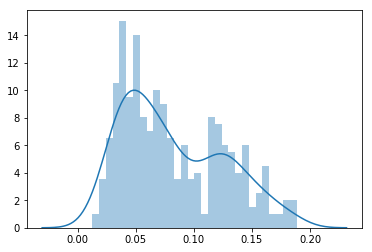

In [32]:
for key, val in recognize_failed_dic.items():
    recognize_failed_dic[key] /= word_frequency_dic[key] # word별로 인식 실패 비율 계산

sns.distplot(list(recognize_failed_dic.values()), bins=30)

### word들 사이에 인식률 차이가 많이 나는 편

In [33]:
sorted(((val, key) for key, val in recognize_failed_dic.items()), reverse=True)[:10]

[(0.18836401081220233, 'stove'),
 (0.1859390080769426, 'bat'),
 (0.1855685784061045, 'eraser'),
 (0.1840481009044112, 'string bean'),
 (0.18236766185285877, 'hot tub'),
 (0.18167161365534235, 'lion'),
 (0.17861118107293453, 'cow'),
 (0.1777624701162932, 'dresser'),
 (0.17313674991533368, 'elephant'),
 (0.17223602046492678, 'monkey')]

In [34]:
sorted(((val, key) for key, val in recognize_failed_dic.items()), reverse=True)[-10:]

[(0.02446307863438008, 'piano'),
 (0.023933583712196085, 'vase'),
 (0.02242652488554128, 'house'),
 (0.022267492620463143, 'cloud'),
 (0.02167735649914752, 'triangle'),
 (0.02078628618353521, 'pear'),
 (0.020424941965437194, 'bucket'),
 (0.018634751896564935, 'line'),
 (0.01570485166257384, 'clock'),
 (0.012542867278962514, 'rainbow')]

### 모델 학습 및 평가를 위해 커널을 재시작 후 아래 셀부터 실행

# Data loading

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import ast
import numpy as np
import cv2

import os
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict

### label을 indexing하여 {label:idx} 사전 생성

In [2]:
label2idx = defaultdict(lambda: len(label2idx))

path_to_dir = 'train_data/'
file_name_ls = os.listdir(path_to_dir)
file_name_ls.pop(file_name_ls.index('.ipynb_checkpoints'))
for file_name in file_name_ls:
    path_to_file = path_to_dir + file_name
    label = pd.read_csv(path_to_file, nrows=1, engine='python')['word'][0]
    
    label2idx[label] # label2idx 사전에 등록

In [3]:
for i, (key, val) in enumerate(label2idx.items()):
    print(key, val)
    
    if i == 5:
        break

horse 0
steak 1
wristwatch 2
blackberry 3
crown 4
cello 5


In [4]:
cc2idx = defaultdict(lambda: len(cc2idx))
cc2idx['<UNK>'] # unk for less frequent country codes
path_to_dir = 'train_data/'
file_name = 'snowman.csv'
path_to_file = path_to_dir + file_name

country_code_ls = list(set(pd.read_csv(path_to_file, engine='python')['countrycode']))

for code in country_code_ls:
    cc2idx[code]

In [5]:
len(cc2idx)

190

In [6]:
import torch

In [7]:
class QuickDrawDataset(Dataset):
    def __init__(self, path_to_file, cc2idx, label2idx, img_size=224, mode='train'):
        self.path_to_file = path_to_file
        self.cc2idx = cc2idx
        self.label2idx = label2idx
        self.img_size = img_size # ResNet101 default input size
        self.mode = mode
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        chunk_size = 1000000
        
        if self.mode == 'train':
            use_col_ls = ['countrycode', 'drawing', 'word']
            self.df = pd.concat(
                [chunk for chunk in pd.read_csv(self.path_to_file, usecols=use_col_ls, chunksize=chunk_size)]
            )
            self.label = [label2idx[w] for w in self.df['word']] #[[label, label, label]]
        else :
            self.df = pd.concat([chunk for chunk in pd.read_csv(self.path_to_file, chunksize=chunk_size)])
            
            
    @staticmethod
    def to_pixel_matrix(drawing_ls, size=224, lw=6, time_color=True):
        '''
        점의 좌표(x,y)로 이뤄진 list를 224x224 정방형 pixel matrix로 변환하는 함수

        arguments
        ===============================================
        drawing_ls : list
            - 사진을 표현한 그래프 좌표(x,y)가 담긴 리스트
            - 'drawings' column

        size : int, default=224
            - pixel matrix의 길이 
            - default=224는 ResNet101의 default input size

        lw : int
            - tickness, 선분의 두께 

        time_color = bool
            - True : 선의 색(color)을 decay 시켜 선을 그리는 순서를 표현, 그림을 그리는 패턴을 포착하기 위함
            - False : 동일한 색으로 선을 표현
        '''
        base_size = 256
        img = np.zeros((base_size, base_size), np.uint8)
        for t, drawing in enumerate(drawing_ls):
            for i in range(len(drawing[0]) - 1):
                color = 255 - min(t, 10)*20 if time_color else 255
                img = cv2.line(
                    img, 
                    (drawing[0][i], drawing[1][i]),
                    (drawing[0][i + 1], drawing[1][i + 1]), 
                    color=color, 
                    thickness=lw,
                )

        return cv2.resize(img, (size, size))
    
    def to_tensor(self, x, dtype=torch.float32):
        return torch.tensor(x, dtype=dtype, device=self.device)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        country_code = self.df['countrycode'][idx]
        if country_code in self.cc2idx:
            country_code = self.cc2idx[country_code]
        else:
            country_code = self.cc2idx['<UNK>']
        country_code = self.to_tensor(country_code, dtype=torch.long)
        
        drawing_ls = ast.literal_eval(self.df['drawing'][idx])
        img = self.to_pixel_matrix(drawing_ls, size=self.img_size, lw=6, time_color=True)
        img = self.to_tensor(img[None]/255, dtype=torch.float32) # expand_dim, bound to 0~1
            
        if self.mode == 'train' or self.mode == 'validtaion':
            label = self.label[idx]
            label = self.to_tensor(label, dtype=torch.long)
            return img, country_code, label 
        else:
            return img, country_code


In [8]:
train_dataset = QuickDrawDataset(
    path_to_file='train_data.csv',
    label2idx = label2idx,
    cc2idx = cc2idx,
)

In [9]:
val_dataset = QuickDrawDataset(
    path_to_file='validtaion_data.csv',
    label2idx = label2idx,
    cc2idx = cc2idx
)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0)

# Model

In [11]:
import torchvision
import torch

In [12]:
resnet = torchvision.models.resnet50(pretrained=True)
resnet.conv1 = torch.nn.Conv2d(1, 64, (7,7), stride=(2,2), padding=(3,3), bias=False) # in-channel customizing
resnet.fc = torch.nn.Linear(2048, 384, bias=True) # output_dim customizing

In [13]:
class DrawingClassifier(torch.nn.Module):
    def __init__(self, img_net):
        super(DrawingClassifier, self).__init__()
        self.img_net = img_net
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.cc_embedding = torch.nn.Embedding(
            num_embeddings=190, #number of country code 
            embedding_dim=128,
        )
        
        self.fc = torch.nn.Linear(384+128, 340, bias=True)  # 384(resent) + 128(cc_embedding)
    
    def to_tensor(self, x, dtype=torch.float32):
        return torch.tensor(x, dtype=dtype, device=self.device)
    
    def forward(self, img, cc):
        img = self.img_net(img)
        cc = self.cc_embedding(cc)
        x = torch.cat((img, cc), dim=1) # img + country_code
        
        out = self.fc(x)
        return torch.log_softmax(out, dim=-1)        

In [14]:
model = DrawingClassifier(resnet)
model.load_state_dict(torch.load('resnet_0.855'))
model.to(model.device)

DrawingClassifier(
  (img_net): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          

In [15]:
for batch in train_loader:
    break

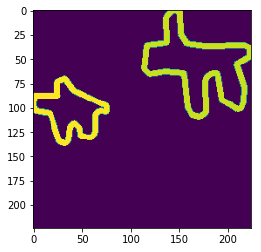

In [16]:
plt.imshow(np.array(batch[0][0].cpu().numpy()*255, dtype=np.uint8)[0])

In [17]:
import time

In [24]:
class Fitter() : 
    def __init__(self, model, train_loader, test_loader): 
        self.criterion = torch.nn.NLLLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(
            self.optimizer, milestones=[25000], gamma=0.5
        )
        self.device = torch.device('cuda' if torch.cuda.is_availa
            print('Epoch: %s\n Train'%epoch)ble() else 'cpu')
        self.model = model.to(model.device)
        
        self.train_loader = train_loader
        self.test_loader = test_loader
    
    def train_and_evaluate(self, n_epoch, save_path, test_epoch=1):       
        for epoch in range(1, n_epoch+1):
            print('=====================================================================================')
            print('Epoch: %s\n Train'%epoch)
            train_loss, train_score = self.train()
            
            if epoch % test_epoch == 0:
                print('=====================================================================================')
                print('Test')
                test_loss, test_score = self.evaluate()
        return
    
    def save_weight(self, path_to_file):
        torch.save(self.model.state_dict(), path_to_file)
        return
    
    def mapk(self, output, target, k=3):
        with torch.no_grad():
            batch_size = target.size(0)

            _, pred = output.topk(k, dim=1)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            for i in range(k):
                correct[i] = correct[i]*(k-i)

            score = correct[:k].view(-1).float().sum(0, keepdim=True)
            score.mul_(1.0 / (k * batch_size))
        return score
    
    def train(self):
        self.model.train()
        start_time = time.time()
        
        epoch_loss, score = 0, 0
        n_batch = 0
        
        for img_batch, cc_batch, y_batch in self.train_loader:
            output = self.model(img_batch, cc_batch) 
            loss = self.criterion(output, y_batch)

            self.optimizer.zero_grad() 
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            epoch_loss += loss.item()
            score += self.mapk(output, y_batch).item()
            n_batch += 1
            
            if n_batch % 1000 == 0:
                print('Batch : %s, Loss : %.03f, Score : %.03f, Train Time : %.03f'\
                      %(n_batch, epoch_loss/n_batch, score/n_batch, time.time()-start_time))

            # 5000 batch씩만 학습
            if n_batch % 5000 == 0:
                break 
                
        return epoch_loss/n_batch, score/n_batch
    
    def evaluate(self):
        model.eval() # stop the every change in gradient of model
        start_time = time.time()
        
        epoch_loss, score = 0, 0
        n_batch = 0
        
        for img_batch, cc_batch, y_batch in self.test_loader:
            output = self.model(img_batch, cc_batch) 
            loss = self.criterion(output, y_batch)

            epoch_loss += loss.item()
            score += self.mapk(output, y_batch).item()
            n_batch += 1
            
            # 1000 배치씩만 테스트
            if n_batch % 1000 == 0:
                self.save_weight('resnet_%.03f'%(score/n_batch)) # save model

                print('Batch : %s, Loss : %.03f, Score : %.03f, Test Time : %.03f'\
                      %(n_batch, epoch_loss/n_batch, score/n_batch, time.time() - start_time))
                break
                
        return epoch_loss/n_batch, score/n_batch
    
    
    

SyntaxError: invalid syntax (<ipython-input-24-c4a01c952055>, line 9)

In [25]:
args = {
    'model' : model,
    'train_loader' : train_loader,
    'test_loader' : val_loader,
}

fitter = Fitter(**args)

In [ ]:
fitter.train_and_evaluate(n_epoch=10, save_path='resnet_weight')

Epoch: 1
 Train
Batch : 1000, Loss : 1.072, Score : 0.818, Train Time : 272.063
Batch : 2000, Loss : 1.072, Score : 0.819, Train Time : 538.206
Batch : 3000, Loss : 1.071, Score : 0.819, Train Time : 803.637
Batch : 4000, Loss : 1.068, Score : 0.820, Train Time : 1070.402
Batch : 5000, Loss : 1.063, Score : 0.821, Train Time : 1337.366
Test
Batch : 1000, Loss : 1.046, Score : 0.825, Test Time : 118.034
Epoch: 2
 Train
Batch : 1000, Loss : 1.027, Score : 0.827, Train Time : 269.394
Batch : 2000, Loss : 1.018, Score : 0.828, Train Time : 540.611
Batch : 3000, Loss : 1.019, Score : 0.828, Train Time : 812.341
Batch : 4000, Loss : 1.017, Score : 0.829, Train Time : 1222.035
Batch : 5000, Loss : 1.015, Score : 0.830, Train Time : 1715.148
Test
Batch : 1000, Loss : 0.981, Score : 0.835, Test Time : 223.629
Epoch: 3
 Train
Batch : 1000, Loss : 0.934, Score : 0.845, Train Time : 532.933
Batch : 2000, Loss : 0.920, Score : 0.847, Train Time : 1048.797


# Predict (Test)

In [ ]:
test_dataset = QuickDrawDataset(
    path_to_file= 'test_simplified.csv',
    label2idx = label2idx,
    cc2idx = cc2idx,
    mode='test'
)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [ ]:
def predict(model, test_loader):
    result = np.array([])
    
    for i, (img_batch, cc_batch) in enumerate(test_loader):
        output = model(img_batch, cc_batch) 
        output = output.topk(3, dim=1)[1].cpu().numpy()
        
        if i == 0:
            result = output
        else:
            result = np.vstack((result, output))
    
    return result
        

In [ ]:
pred_ls = predict(fitter.model, test_loader)

In [ ]:
# decode
idx2label = {val : key for key,val in label2idx.items()}
pred_ls = [[idx2label[pred] for pred in preds] for preds in pred_ls] # idx2label
pred_ls = [' '.join(preds) for preds in pred_ls] # join

# save    
submission = pd.read_csv('test_simplified.csv')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = pred_ls

In [ ]:
submission.to_csv('submission.csv', index=False)